In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import utils

In [2]:
learning_rate_anr_capex = 0
learning_rate_h2_capex = 0
csv_path = './results/process_heat_anr_lr_'+str(learning_rate_anr_capex)+'_h2_lr_'+str(learning_rate_h2_capex)+'_wacc_'+str(utils.WACC)+'.csv'
clean_save_path = './results/process_heat_anr_lr_'+str(learning_rate_anr_capex)+'_h2_lr_'+str(learning_rate_h2_capex)+'_wacc_'+str(utils.WACC)+'_clean.csv'
save_fig_path = './results/process_heat_anr_lr_'+str(learning_rate_anr_capex)+'_h2_lr_'+str(learning_rate_h2_capex)+'_wacc_'+str(utils.WACC)+'.png'

In [3]:
df = pd.read_csv(csv_path)
df.sort_values(by=['Breakeven NG price ($/MMBtu)'], inplace=True)
df.reset_index(inplace=True)
df.drop(columns=['index'], inplace=True)

In [4]:
anr_param = pd.read_excel('ANRs.xlsx', sheet_name='FOAK')

### Compute deployed power at each steel plant and cumulative deployed ANR capacity

In [5]:
anr_thermal_power = anr_param[['Power in MWt', 'Reactor']]
anr_thermal_power
df = df.merge(anr_thermal_power, how='inner', left_on=['ANR type'], right_on=['Reactor'])
df.sort_values(by=['Breakeven NG price ($/MMBtu)'], inplace=True)
df['Deployed Power (MWt)'] = df['Power in MWt']*df['# ANR modules']
df['ANR Nameplate Capacity (GWt)'] = df['Deployed Power (MWt)'].cumsum()/1000
df['Cum dem (t/day)'] = df['H2 Dem. (kg/day)'].cumsum()/1000
df.tail(105)

,FACILITY_ID,H2 Dem. (kg/day),Heat Dem. (MJ/year),Cost ($/year),Ann. carbon emissions (kgCO2eq/year),PEM,Alkaline,HTSE,ANR type,# ANR modules,Breakeven NG price ($/MMBtu),Power in MWt,Reactor,Deployed Power (MWt),ANR Nameplate Capacity (GWt),Cum dem (t/day)
188,1003965,10401.568184,5.386577e+08,-2.007470e+07,827693.856,0.0,0.0,11.0,Micro,2,39.319823,20,Micro,40,17.18,6454.891776
189,1006391,10375.757028,5.373210e+08,-2.006728e+07,827693.856,0.0,0.0,11.0,Micro,2,39.403067,20,Micro,40,17.22,6465.267533
190,1000272,5151.985434,2.668017e+08,-1.006586e+07,451469.376,0.0,0.0,6.0,Micro,1,39.805022,20,Micro,20,17.24,6470.419519
191,1000342,10058.026671,5.208670e+08,-1.997594e+07,827693.856,0.0,0.0,11.0,Micro,2,40.462790,20,Micro,40,17.28,6480.477545
192,1007577,10057.419444,5.208355e+08,-1.997576e+07,827693.856,0.0,0.0,11.0,Micro,2,40.464879,20,Micro,40,17.32,6490.534965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,1006336,233.209349,1.207703e+07,-8.226431e+06,75244.896,0.0,0.0,1.0,Micro,1,718.665648,20,Micro,20,19.50,6840.046955
289,1005537,199.690785,1.034123e+07,-8.216795e+06,75244.896,0.0,0.0,1.0,Micro,1,838.312304,20,Micro,20,19.52,6840.246646
290,1006263,185.983880,9.631398e+06,-8.212855e+06,75244.896,0.0,0.0,1.0,Micro,1,899.663804,20,Micro,20,19.54,6840.432630
291,1002884,74.293726,3.847390e+06,-8.180748e+06,75244.896,0.0,0.0,1.0,Micro,1,2243.376993,20,Micro,20,19.56,6840.506923


### Compute cumulative number of viable steel plants and ANR modules

In [6]:
df['Viable ANR modules count'] = df['# ANR modules'].cumsum()
df.reset_index(inplace=True)
df.drop(columns=['index'], inplace=True)
df['Viable ANR plants count'] = df.index+1
df.head(5)

,FACILITY_ID,H2 Dem. (kg/day),Heat Dem. (MJ/year),Cost ($/year),Ann. carbon emissions (kgCO2eq/year),PEM,Alkaline,HTSE,ANR type,# ANR modules,Breakeven NG price ($/MMBtu),Power in MWt,Reactor,Deployed Power (MWt),ANR Nameplate Capacity (GWt),Cum dem (t/day),Viable ANR modules count,Viable ANR plants count
0,1000588,153100.342414,7.928485e+09,-1.363289e+08,1.444336e+07,0.0,0.0,154.0,iMSR,1,18.141498,300,iMSR,300,0.3,153.100342,1,1
1,1007177,150959.177564,7.817602e+09,-1.353952e+08,1.416200e+07,0.0,0.0,151.0,iMSR,1,18.272802,300,iMSR,300,0.6,304.059520,2,2
2,1000418,433411.991729,2.244476e+10,-3.985748e+08,4.070402e+07,0.0,0.0,434.0,iMSR,3,18.735716,300,iMSR,900,1.5,737.471512,5,3
3,1005198,141178.307699,7.311088e+09,-1.316290e+08,1.331791e+07,0.0,0.0,142.0,iMSR,1,18.995249,300,iMSR,300,1.8,878.649819,6,4
4,1000630,177254.463397,9.179335e+09,-1.664801e+08,1.609177e+07,0.0,0.0,178.0,PBR-HTGR,2,19.134915,200,PBR-HTGR,400,2.2,1055.904283,8,5


### Compute avoided carbon emissions 

In [7]:
demand_heat_df = pd.read_excel('./h2_demand_industry_heat.xlsx', sheet_name='max')
demand_heat_df = demand_heat_df[['FACILITY_ID', 'MMTCO2E']]
demand_heat_df.head(3)

,FACILITY_ID,MMTCO2E
0,1000022,0.004963
1,1000029,0.033338
2,1000056,0.041385


In [8]:
df = df.merge(demand_heat_df, on='FACILITY_ID')
df.head(3)

,FACILITY_ID,H2 Dem. (kg/day),Heat Dem. (MJ/year),Cost ($/year),Ann. carbon emissions (kgCO2eq/year),PEM,Alkaline,HTSE,ANR type,# ANR modules,Breakeven NG price ($/MMBtu),Power in MWt,Reactor,Deployed Power (MWt),ANR Nameplate Capacity (GWt),Cum dem (t/day),Viable ANR modules count,Viable ANR plants count,MMTCO2E
0,1000588,153100.342414,7.928485e+09,-1.363289e+08,1.444336e+07,0.0,0.0,154.0,iMSR,1,18.141498,300,iMSR,300,0.3,153.100342,1,1,0.399145
1,1007177,150959.177564,7.817602e+09,-1.353952e+08,1.416200e+07,0.0,0.0,151.0,iMSR,1,18.272802,300,iMSR,300,0.6,304.059520,2,2,0.393562
2,1000418,433411.991729,2.244476e+10,-3.985748e+08,4.070402e+07,0.0,0.0,434.0,iMSR,3,18.735716,300,iMSR,900,1.5,737.471512,5,3,1.129939


In [14]:
df['Ann. avoided CO2 emissions (MMT-CO2/year)'] = df.apply(lambda row: row['MMTCO2E']- row['Ann. carbon emissions (kgCO2eq/year)']/1e9, axis=1)
df['Viable avoided emissions (MMT-CO2/year)'] = df['Ann. avoided CO2 emissions (MMT-CO2/year)'].cumsum()
df[['Breakeven NG price ($/MMBtu)', 'Viable avoided emissions (MMT-CO2/year)']].tail(355)


,Breakeven NG price ($/MMBtu),Viable avoided emissions (MMT-CO2/year)
0,18.141498,0.384701
1,18.272802,0.764102
2,18.735716,1.853337
3,18.995249,2.208082
4,19.134915,2.654106
...,...,...
288,718.665648,17.345793
289,838.312304,17.346238
290,899.663804,17.346648
291,2243.376993,17.346766


### Save clean version of results


In [10]:
df_clean = df[["FACILITY_ID", 'H2 Dem. (kg/day)', 'HTSE', 'ANR type', '# ANR modules', 'Cost ($/year)','Breakeven NG price ($/MMBtu)', 'Ann. avoided CO2 emissions (MMT-CO2/year)']]
df_clean


,FACILITY_ID,H2 Dem. (kg/day),HTSE,ANR type,# ANR modules,Cost ($/year),Breakeven NG price ($/MMBtu),Ann. avoided CO2 emissions (MMT-CO2/year)
0,1000588,153100.342414,154.0,iMSR,1,-1.363289e+08,18.141498,0.384701
1,1007177,150959.177564,151.0,iMSR,1,-1.353952e+08,18.272802,0.379400
2,1000418,433411.991729,434.0,iMSR,3,-3.985748e+08,18.735716,1.089235
3,1005198,141178.307699,142.0,iMSR,1,-1.316290e+08,18.995249,0.354745
4,1000630,177254.463397,178.0,PBR-HTGR,2,-1.664801e+08,19.134915,0.446025
...,...,...,...,...,...,...,...,...
288,1006336,233.209349,1.0,Micro,1,-8.226431e+06,718.665648,0.000533
289,1005537,199.690785,1.0,Micro,1,-8.216795e+06,838.312304,0.000445
290,1006263,185.983880,1.0,Micro,1,-8.212855e+06,899.663804,0.000410
291,1002884,74.293726,1.0,Micro,1,-8.180748e+06,2243.376993,0.000118


In [11]:
df_clean['HTSE'] = df_clean['HTSE'].apply(lambda x: int(x))
df_clean['H2 Dem. (kg/day)'] = df_clean['H2 Dem. (kg/day)'].apply(lambda x:np.round(x/1e3,2))
df_clean['Avoided cost of CO2 ($/ton)'] = df_clean['Cost ($/year)']/df_clean['Ann. avoided CO2 emissions (MMT-CO2/year)']
df_clean['Avoided cost of CO2 ($/ton)'] = df_clean['Avoided cost of CO2 ($/ton)'].apply(lambda x:np.round(np.abs(x)/1e6,1))
df_clean['Cost ($/year)'] = df_clean['Cost ($/year)'].apply(lambda x: np.round(-x/1e6,1))
df_clean['Ann. avoided CO2 emissions (MMT-CO2/year)']= df_clean.apply(lambda x: np.round(x['Ann. avoided CO2 emissions (MMT-CO2/year)'],3), axis=1)

df_clean["Breakeven NG price ($/MMBtu)"] = df_clean.apply(lambda row : np.round(row['Breakeven NG price ($/MMBtu)'],1), axis=1)
df_clean.rename(columns={'H2 Dem. (kg/day)': 'Demand (MT H2/day)',
                         'Cost ($/year)': 'Cost (M$/year)', 
                         'ANR type': 'ANR', 
                         '# ANR modules': '#'}, inplace=True)
df_clean.sort_values(by=['Breakeven NG price ($/MMBtu)'], inplace=True)
df_clean.to_csv(clean_save_path, index=False)

C:\Users\mgarrou\AppData\Local\Temp\ipykernel_5752\1656952344.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['HTSE'] = df_clean['HTSE'].apply(lambda x: int(x))
C:\Users\mgarrou\AppData\Local\Temp\ipykernel_5752\1656952344.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['H2 Dem. (kg/day)'] = df_clean['H2 Dem. (kg/day)'].apply(lambda x:np.round(x/1e3,2))
C:\Users\mgarrou\AppData\Local\Temp\ipykernel_5752\1656952344.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy

### Plots

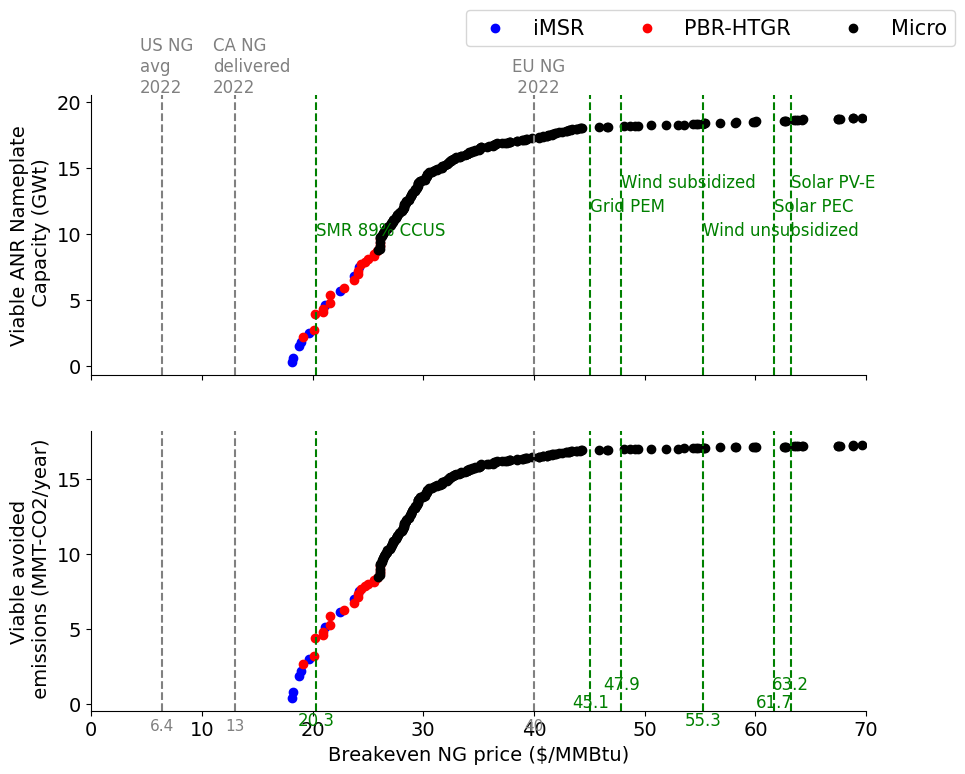

In [12]:
#Use latex font
#plt.rcParams['text.usetex'] = True
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['font.size'] = 14

# Create subplots
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(10, 8))

# Get unique ANR types and assign colors
anr_types = df['ANR type'].unique()

colors = ['blue', 'red', 'black']  # Adjust the colors according to the unique ANR types
# Initialize empty handles for legend
handles = []
# Plotting the data as scatter plots with different colors for each ANR type
labels = {'ANR Nameplate Capacity (GWt)': 'Viable ANR Nameplate\n Capacity (GWt)',
            'Viable avoided emissions (MMT-CO2/year)': 'Viable avoided\n emissions (MMT-CO2/year)'}
for i, col in enumerate(['ANR Nameplate Capacity (GWt)', 'Viable avoided emissions (MMT-CO2/year)']):
    for anr_type, color in zip(anr_types, colors):
        subset = df[df['ANR type'] == anr_type]
        axs[i].scatter(subset['Breakeven NG price ($/MMBtu)'], subset[col], color=color, label=f'{anr_type}')
    axs[i].set_ylabel(labels[col])

    # Remove the top and right spines
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)

    axs[i].set_xlim([0,70])

    # Adding vertical lines
    res_be = pd.read_csv('./results/res_be_heat_process.csv')
    res_be.sort_values(by='Breakeven price ($/MMBtu)', inplace=True)
    res_be['Breakeven price ($/MMBtu)'] = res_be.apply(lambda x:np.round(x['Breakeven price ($/MMBtu)'],1), axis=1)

    ng_vertical_lines = [6.4, 13, 40]
    ng_labels = ['US NG\navg 2022', 'CA NG\ndelivered 2022', 'EU NG\n 2022']
    res_vert_lines = list(res_be['Breakeven price ($/MMBtu)'])
    for line in ng_vertical_lines:
        axs[i].axvline(x=line, linestyle='--', color='grey')
    for l,line in enumerate(res_vert_lines):
        axs[i].axvline(x=line, linestyle='--',color='green')


ng_labels = ['US NG\navg\n2022', 'CA NG\ndelivered\n2022', 'EU NG\n 2022']
for x, l in zip(ng_vertical_lines, ng_labels):
    axs[0].text(x-2, axs[0].get_ylim()[1]+0.2, l, fontsize=12, color='grey')
    axs[1].text(x, axs[1].get_ylim()[0]-0.5, str(x), color='grey', fontsize=11, va='top', ha='center')

res_labels = res_be['RES']
count = 0
for x, label in zip(res_vert_lines, res_labels):
    axs[0].text(x, (axs[0].get_ylim()[1]+axs[0].get_ylim()[0])/2+1.8*np.mod(count,3), label, fontsize=12, color='green')
    axs[1].text(x, axs[1].get_ylim()[0]+1.2*np.mod(count,3), str(x), color='green', fontsize=12, va='top',ha='center')
    count+=1


# Setting the title and labels
plt.xlabel('Breakeven NG price ($/MMBtu)')


# Add a common legend for all subplots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol=len(anr_types))
#fig.tight_layout()
#plt.show()
plt.savefig(save_fig_path)